In [1]:
import gzip, struct
import numpy as np
import torch.utils.data as data

class MnistDataset(data.Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            X, y = self._read('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
        else:
            X, y = self._read('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
            
        self.images = torch.from_numpy(X.reshape(-1, 1, 28, 28)).float()
        self.labels = torch.from_numpy(y.astype(int))
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)

    def _read(self, image, label):
        with gzip.open(self.path + image, 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            X = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(-1, rows, cols)
        with gzip.open(self.path + label) as flbl:
            magic, num = struct.unpack(">II", flbl.read(8))
            y = np.frombuffer(flbl.read(), dtype=np.int8)
        return X, y

In [2]:
import torch

train_dataset = MnistDataset('./data/')
train_loader = data.DataLoader(dataset=train_dataset, shuffle=True, 
                          batch_size=256, num_workers=4, pin_memory=True)

test_dataset = MnistDataset('./data/', train=False)
test_loader = data.DataLoader(dataset=test_dataset, shuffle=True,
                         batch_size=256, num_workers=4, pin_memory=True)

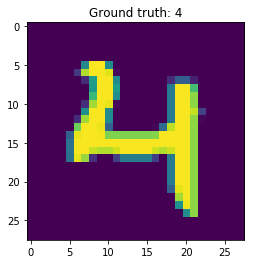

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img, label):
    plt.imshow(img.reshape((28, 28)))
    plt.title('Ground truth: ' + str(label.item()))

X, y = iter(train_loader).next()
imshow(X[0], y[0])

In [4]:
from torch import nn
from torch.nn import functional as F
import torchvision

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        features = []
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        features.append(x) # C1
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        features.append(x) # C3
        x = F.max_pool2d(x, 2)
        features.append(x) # S4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, features

    
net = LeNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

net.to(device)

Using device: cuda:0


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

def weight_init(m):
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))

net.apply(weight_init)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
def train(epoch):
    total_loss = 0.0
    for batch_idx, (inputs, label) in enumerate(train_loader):
        inputs, label = inputs.to(device), label.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = net(inputs)[0]
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 64 == 63:
            total_loss += loss.item()
            print('[{}, {:5d}] Loss: {:.3f}'.format(
                epoch + 1, batch_idx + 1, total_loss / 64))
            total_loss = 0.0
def test():
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            output = net(inputs)[0]
            # sum up batch loss
            test_loss += criterion(output, label).item()
            # get the index of the max log-probability
            predict = output.data.max(1, keepdim=True)[1]
            correct += predict.eq(label.data.view_as(predict)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest Accuracy: {:.2f}%\n'.format(
        100.0 * correct / len(test_loader.dataset)))

for epoch in range(5):
    train(epoch)
    test()

print('Finished!')

[1,    64] Loss: 0.885
[1,   128] Loss: 0.553
[1,   192] Loss: 0.293

Test Accuracy: 96.78%

[2,    64] Loss: 0.353
[2,   128] Loss: 0.349
[2,   192] Loss: 0.174

Test Accuracy: 97.98%

[3,    64] Loss: 0.268
[3,   128] Loss: 0.040
[3,   192] Loss: 0.208

Test Accuracy: 98.39%

[4,    64] Loss: 0.192
[4,   128] Loss: 0.133
[4,   192] Loss: 0.408

Test Accuracy: 98.55%

[5,    64] Loss: 0.088
[5,   128] Loss: 0.162
[5,   192] Loss: 0.016

Test Accuracy: 98.24%

Finished!


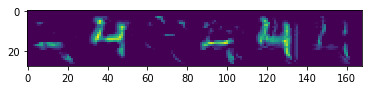

In [7]:
import torchvision

X = X.to(device)
features = net(X)[1] # [C1, C3, S4]
C1 = features[0][0].detach().cpu() # [6, 28, 28]
plt.imshow(torch.cat((C1[0], C1[1], C1[2], C1[3], C1[4], C1[5]), dim=1))